In [3]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

In [4]:
modis_sent = parallel_rw_pkl(None,'patch15MS','r')
patch15Sen = parallel_rw_pkl(None, 'patch15Sen', 'r')

cm = parallel_rw_pkl(None, '0510diacm', 'r')[1000:2000,5000:6000]
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

### Band 2 approximation of slope

patch 15
costs: 0.0248450447385 rvalue:  0.975154955261 slop:  1.27075868706 
parameters:  [-20.345653    60.34353532] 

patch 15
costs: 0.024525243276 rvalue:  0.975474756724 slop:  1.27023535046 
parameters:  [-21.36293565  60.34353532] 

patch 15
costs: 0.0272996533525 rvalue:  0.972700346647 slop:  1.25868851587 
parameters:  [-20.345653    63.36071209] 

patch 15
costs: 0.0239458665487 rvalue:  0.976054133451 slop:  1.27784260193 
parameters:  [-21.36293565  57.32635855] 

patch 15
costs: 0.0240221572179 rvalue:  0.975977842782 slop:  1.28395676224 
parameters:  [-21.87157697  54.30918179] 

patch 15
costs: 0.0241126134155 rvalue:  0.975887386585 slop:  1.27850180881 
parameters:  [-22.3802183   57.32635855] 

patch 15
costs: 0.0242354174614 rvalue:  0.975764582539 slop:  1.28453007528 
parameters:  [-22.3802183   54.30918179] 

patch 15
costs: 0.0241249232928 rvalue:  0.975875076707 slop:  1.28236463818 
parameters:  [-22.12589764  55.81777017] 

patch 15
costs: 0.024060489751 rv

<ipython-input-13-d4e82a1d289c>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


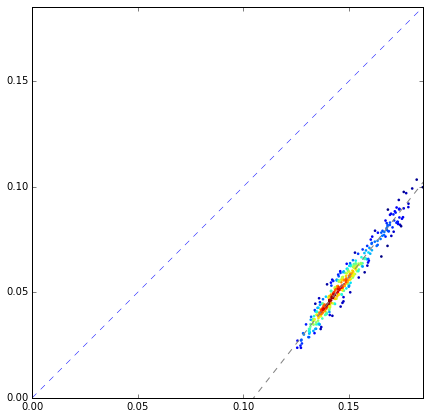

In [13]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[:1]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[0][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-20.345653,60.34353532])
        bound = np.array([(-100., 100.),(-100.,100.)])
        psolve = optimize.fmin(cost,p, full_output=1,args=(([i,j],)))
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve1 = solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 3 approximation of slope

patch 15
costs: 0.0189873374911 rvalue:  0.981012662509 slop:  1.31704503613 
parameters:  [-20.345653    60.34353532] 

patch 15
costs: 0.0189119061981 rvalue:  0.981088093802 slop:  1.31682871775 
parameters:  [-21.36293565  60.34353532] 

patch 15
costs: 0.0203665339565 rvalue:  0.979633466043 slop:  1.30594471599 
parameters:  [-20.345653    63.36071209] 

patch 15
costs: 0.0190942660073 rvalue:  0.980905733993 slop:  1.32379575986 
parameters:  [-21.36293565  57.32635855] 

patch 15
costs: 0.0189579673462 rvalue:  0.981042032654 slop:  1.32175347532 
parameters:  [-21.10861499  58.83494694] 

patch 15
costs: 0.0192353535073 rvalue:  0.980764646493 slop:  1.32227021901 
parameters:  [-22.12589764  58.83494694] 

patch 15
costs: 0.0189322637295 rvalue:  0.981067736271 slop:  1.31957127576 
parameters:  [-20.79071416  59.96638822] 

patch 15
costs: 0.0188804704378 rvalue:  0.981119529562 slop:  1.31276356293 
parameters:  [-21.04503482  61.47497661] 

patch 15
costs: 0.0198041999915 

<ipython-input-14-79c5c36c7248>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


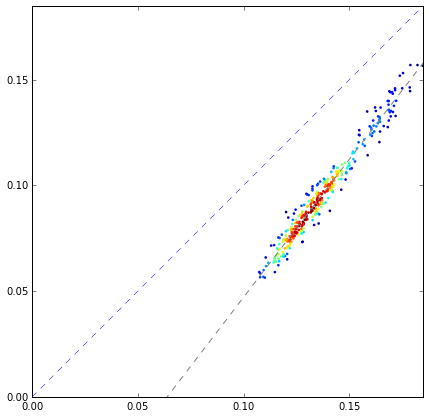

In [14]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[1:2]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[1][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-20.345653,60.34353532])
        bound = np.array([(-100., 100.),(-100.,100.)])
        psolve = optimize.fmin(cost,p, full_output=1,args=(([i,j],)))
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve2 = solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 4 approximation of slope

patch 15
costs: 0.0191005032766 rvalue:  0.980899496723 slop:  1.16774775167 
parameters:  [-20.345653    60.34353532] 

patch 15
costs: 0.0188183393256 rvalue:  0.981181660674 slop:  1.16864513902 
parameters:  [-21.36293565  60.34353532] 

patch 15
costs: 0.0213998688089 rvalue:  0.978600131191 slop:  1.15833568816 
parameters:  [-20.345653    63.36071209] 

patch 15
costs: 0.0182352747122 rvalue:  0.981764725288 slop:  1.17527275518 
parameters:  [-21.36293565  57.32635855] 

patch 15
costs: 0.0183503212835 rvalue:  0.981649678716 slop:  1.18031748338 
parameters:  [-21.87157697  54.30918179] 

patch 15
costs: 0.0182823066001 rvalue:  0.9817176934 slop:  1.17591460733 
parameters:  [-22.3802183   57.32635855] 

patch 15
costs: 0.0184467279983 rvalue:  0.981553272002 slop:  1.18088717119 
parameters:  [-22.3802183   54.30918179] 

patch 15
costs: 0.0183140569768 rvalue:  0.981685943023 slop:  1.1791050557 
parameters:  [-22.12589764  55.81777017] 

patch 15
costs: 0.0183586861974 rva

<ipython-input-15-3077d47e0710>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


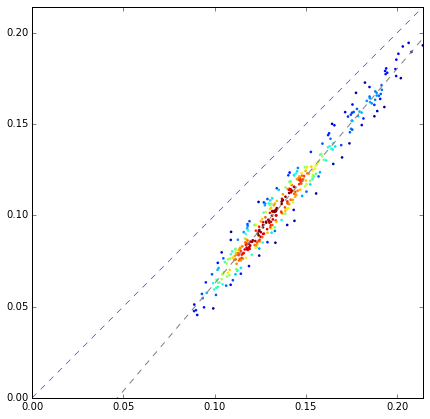

In [15]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[2:3]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[2][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-20.345653,60.34353532])
        psolve = optimize.fmin(cost,p, full_output=1,args=(([i,j],)))
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve3 = solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 8 approximation of slope

patch 15
costs: 0.0496511130403 rvalue:  0.95034888696 slop:  1.09578446061 
parameters:  [-20.345653    60.34353532] 

patch 15
costs: 0.0485361769976 rvalue:  0.951463823002 slop:  1.09602168203 
parameters:  [-21.36293565  60.34353532] 

patch 15
costs: 0.0518222208265 rvalue:  0.948177779173 slop:  1.09572059304 
parameters:  [-20.345653    63.36071209] 

patch 15
costs: 0.0474728483056 rvalue:  0.952527151694 slop:  1.09769204009 
parameters:  [-21.36293565  57.32635855] 

patch 15
costs: 0.04765426838 rvalue:  0.95234573162 slop:  1.09680040707 
parameters:  [-21.87157697  54.30918179] 

patch 15
costs: 0.0470601198174 rvalue:  0.952939880183 slop:  1.09787782751 
parameters:  [-22.3802183   57.32635855] 

patch 15
costs: 0.0469334907492 rvalue:  0.953066509251 slop:  1.09744645783 
parameters:  [-23.39750095  55.81777017] 

patch 15
costs: 0.0478751946422 rvalue:  0.952124805358 slop:  1.09537069334 
parameters:  [-23.39750095  52.80059341] 

patch 15
costs: 0.0473051740948 rval

<ipython-input-16-5b12340443dc>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


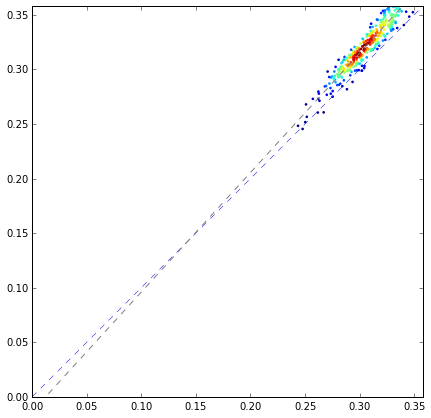

In [16]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[3:4]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[3][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-20.345653,60.34353532])
        psolve = optimize.fmin(cost,p, full_output=1,args=(([i,j],)))
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve4 = solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 8A approximation of slope

patch 15
costs: 0.0501672875493 rvalue:  0.949832712451 slop:  0.951305931496 
parameters:  [-20.345653    60.34353532] 

patch 15
costs: 0.0490329865367 rvalue:  0.950967013463 slop:  0.951930503083 
parameters:  [-21.36293565  60.34353532] 

patch 15
costs: 0.051856276684 rvalue:  0.948143723316 slop:  0.951642784673 
parameters:  [-20.345653    63.36071209] 

patch 15
costs: 0.0484750395847 rvalue:  0.951524960415 slop:  0.952445425984 
parameters:  [-21.36293565  57.32635855] 

patch 15
costs: 0.0491340756724 rvalue:  0.950865924328 slop:  0.95079176511 
parameters:  [-21.87157697  54.30918179] 

patch 15
costs: 0.0481534506017 rvalue:  0.951846549398 slop:  0.952446212106 
parameters:  [-22.3802183   57.32635855] 

patch 15
costs: 0.0484058002441 rvalue:  0.951594199756 slop:  0.951351810419 
parameters:  [-23.39750095  55.81777017] 

patch 15
costs: 0.048876814897 rvalue:  0.951123185103 slop:  0.950717119066 
parameters:  [-22.3802183   54.30918179] 

patch 15
costs: 0.048547437

<ipython-input-17-c680ea6673e1>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


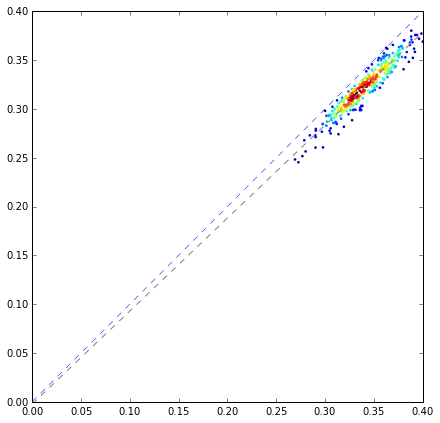

In [17]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[4:5]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[4][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-20.345653,60.34353532])
        psolve = optimize.fmin(cost,p, full_output=1,args=(([i,j],)))
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve5 = solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 11 approximation of slope

patch 15
costs: 0.0418215876598 rvalue:  0.95817841234 slop:  0.954901502827 
parameters:  [-20.345653    60.34353532] 

patch 15
costs: 0.0412776851266 rvalue:  0.958722314873 slop:  0.95869398919 
parameters:  [-21.36293565  60.34353532] 

patch 15
costs: 0.0404283134892 rvalue:  0.959571686511 slop:  0.951787261662 
parameters:  [-20.345653    63.36071209] 

patch 15
costs: 0.0403748475129 rvalue:  0.959625152487 slop:  0.953416249681 
parameters:  [-21.36293565  63.36071209] 

patch 15
costs: 0.0397104980817 rvalue:  0.960289501918 slop:  0.952599424664 
parameters:  [-21.87157697  64.86930047] 

patch 15
costs: 0.0385331263143 rvalue:  0.961466873686 slop:  0.947783307345 
parameters:  [-20.85429432  67.88647724] 

patch 15
costs: 0.0378001360047 rvalue:  0.962199863995 slop:  0.943016217818 
parameters:  [-20.59997366  71.65794819] 

patch 15
costs: 0.037019943985 rvalue:  0.962980056015 slop:  0.94324540355 
parameters:  [-22.12589764  73.16653658] 

patch 15
costs: 0.0383530322

<ipython-input-18-14ca219569e5>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


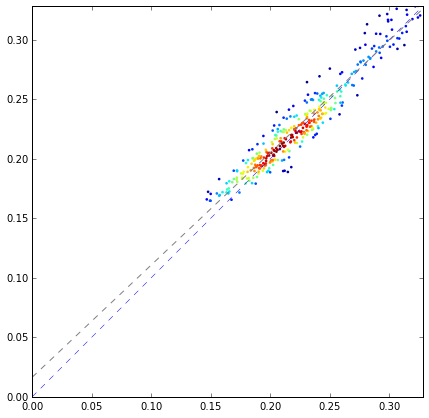

In [18]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[5:6]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[5][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-20.345653,60.34353532])
        psolve = optimize.fmin(cost,p, full_output=1,args=(([i,j],)))
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve6 = solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

### Band 12 approximation of slope

patch 15
costs: 0.0224536118166 rvalue:  0.977546388183 slop:  1.13105409108 
parameters:  [-20.          73.34353532] 

patch 15
costs: 0.0229215180354 rvalue:  0.977078481965 slop:  1.1305766125 
parameters:  [-21.          73.34353532] 

patch 15
costs: 0.0225823255869 rvalue:  0.977417674413 slop:  1.12270614715 
parameters:  [-20.          77.01071209] 

patch 15
costs: 0.0224213797465 rvalue:  0.977578620254 slop:  1.12230743577 
parameters:  [-19.          77.01071209] 

patch 15
costs: 0.0223444242672 rvalue:  0.977655575733 slop:  1.119567974 
parameters:  [-18.          78.84430047] 

patch 15
costs: 0.0220940086247 rvalue:  0.977905991375 slop:  1.12463918918 
parameters:  [-18.         75.1771237] 

patch 15
costs: 0.0219759047067 rvalue:  0.978024095293 slop:  1.12434104558 
parameters:  [-17.          74.26032951] 

patch 15
costs: 0.0221558641146 rvalue:  0.977844135885 slop:  1.11484689837 
parameters:  [-15.          79.76109466] 

patch 15
costs: 0.0215686055594 rvalu

<ipython-input-20-8544e8cc0192>:62: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


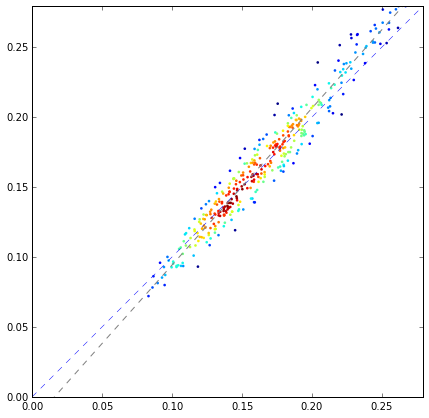

In [20]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]
    
    for k, sen_cut in enumerate(patch15Sen[6:]):
                
        for ii,cx in enumerate(patchx):
            cy = patchy[ii] - 5000
            cx -= 1000
            minx = cx+sx - 50
            maxx = cx+sx + 50
            miny = cy+sy - 50
            maxy = cy+sy + 50

            to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
            brdf = modis_sent[6][cx,cy]*0.001

            if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
                To_conv = to_conv

                Brdf = brdf
                nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
                To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
                gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
                ker = gaus/(gaus.sum())

                s = signal.fftconvolve(To_conv, ker, mode='valid')
                to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([-20,73.34353532])
        psolve = optimize.fmin(cost,p, full_output=1,args=(([i,j],)))
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(-20., 20., 5), slice(-10, 30, 5))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,resbrute ])
        print 'solved one: ', resbrute, '\n'
    return solved 

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

    
psolve7 = solve(([1,5],))

x,y = np.array(to_regression).T
nanm = (np.isnan(x))|(np.isnan(y))
y,x = x[~nanm], y[~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

In [ ]:
def linear_plot(x,y):
    maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
    xy = np.vstack([y,x])
    z = gaussian_kde(xy)(xy)

    fit = np.polyfit(y,x,1)
    fit_fn = np.poly1d(fit)

    fig, ax = plt.subplots(figsize = (7,7))
    ax.scatter(y, x, c=z, s=7, edgecolor='')
    plt.plot([0,1],[0.,1], '--',linewidth=0.5)
    plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    plt.xlim(0, maxval)
    plt.ylim(0, maxval)
    r = scipy.stats.linregress(y,x)
    print r

In [23]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process, sent_cut, modis_sen):    
    xstd,ystd,angle = 140, 240, 45
    sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]          
    
    for ii,cx in enumerate(patchx):
        cy = patchy[ii] - 5000
        cx -= 1000
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        brdf = modis_sen[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs

solved = []
to_regs = []
for ii,sen_cut in enumerate(patch15Sen):
    p = np.array([-20,73.34353532])
    psolve = optimize.fmin(cost,p, full_output=1,args=(([1,5],), sen_cut, modis_sent[ii]))
    solved.append(psolve)
    to_regs.append(to_regression)
    print 'solved one: ', psolve, '\n'

patch 15
costs: 0.0376909740098 rvalue:  0.96230902599 slop:  1.21945762759 
parameters:  [-20.          73.34353532] 

patch 15
costs: 0.0374013217105 rvalue:  0.962598678289 slop:  1.22039258462 
parameters:  [-21.          73.34353532] 

patch 15
costs: 0.0444781503302 rvalue:  0.95552184967 slop:  1.20504113869 
parameters:  [-20.          77.01071209] 

patch 15
costs: 0.032125896737 rvalue:  0.967874103263 slop:  1.23887063033 
parameters:  [-21.          69.67635855] 

patch 15
costs: 0.0288513020696 rvalue:  0.97114869793 slop:  1.24869320319 
parameters:  [-21.5         66.00918179] 

patch 15
costs: 0.0289287140058 rvalue:  0.971071285994 slop:  1.24952182125 
parameters:  [-22.5         66.00918179] 

patch 15
costs: 0.0242143103737 rvalue:  0.975785689626 slop:  1.27627229497 
parameters:  [-23.          58.67482826] 

patch 15
costs: 0.0253862347138 rvalue:  0.974613765286 slop:  1.29089091626 
parameters:  [-24.          51.34047472] 

patch 15
costs: 0.024060489751 rvalu

<ipython-input-23-98e3393c6838>:59: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [24]:
solved

[(array([-21.82421875,  56.32554314]), 0.02391043690604755, 27, 79, 0),
 (array([-21.5625    ,  59.13322535]), 0.018901888818317558, 26, 76, 0),
 (array([-22.        ,  56.84123987]), 0.018208449351385436, 28, 83, 0),
 (array([-23.6640625 ,  57.18503769]), 0.046814415889388283, 27, 80, 0),
 (array([-24.359375  ,  58.56022898]), 0.047922908610639747, 25, 76, 0),
 (array([-21.859375  ,  72.77053895]), 0.03617761065081182, 23, 68, 0),
 (array([-14.       ,  75.1771237]), 0.021568605559435516, 24, 77, 0)]

In [74]:
x.T[0][:-1].mean(),x.T[1][:-2].mean() 

(-22.544921875, 57.609055008381254)

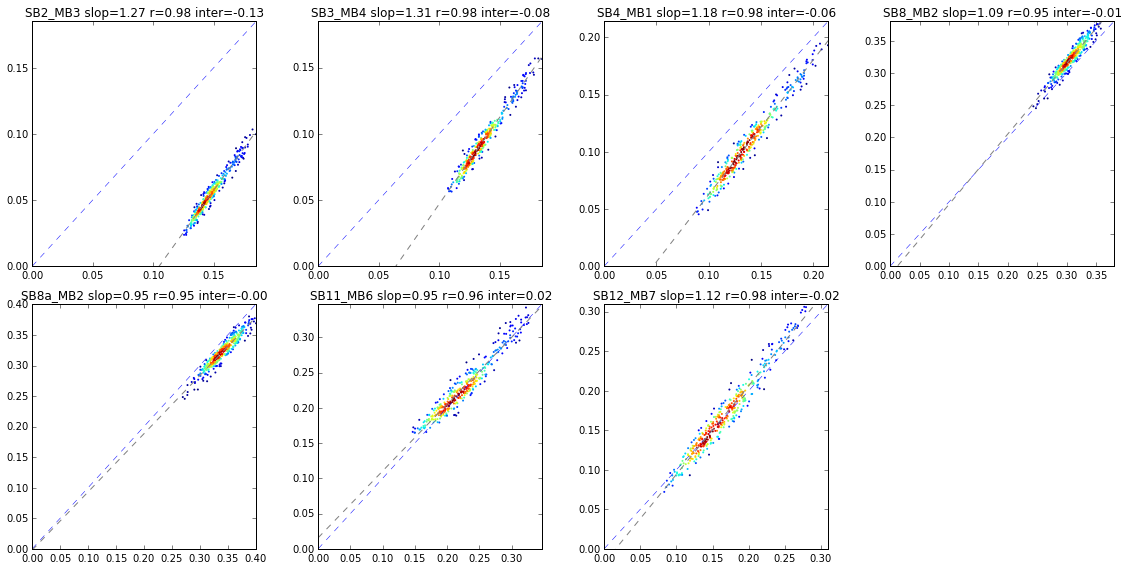

In [34]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(to_regs[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression2.pdf')

In [35]:
def cost(process, sent_cut, modis_sen):    
    #xstd,ystd,angle = 140, 240, 45
    sx, sy = 0,0
    #xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]          
    
    for ii,cx in enumerate(patchx):
        cy = patchy[ii] - 5000
        cx -= 1000
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        brdf = modis_sen[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            s = np.nanmean(To_conv)
            to_regression.append([s, Brdf])
    
    
    return to_regression


to_regs = []
for ii,sen_cut in enumerate(patch15Sen):
    to_r = cost(([1,5],), sen_cut, modis_sent[ii])
    to_regs.append(to_r)
    print 'mean of the %02d pair' %ii

patch 15
mean of the 00 pair
patch 15
mean of the 01 pair
patch 15
mean of the 02 pair
patch 15
mean of the 03 pair
patch 15
mean of the 04 pair
patch 15
mean of the 05 pair
patch 15
mean of the 06 pair


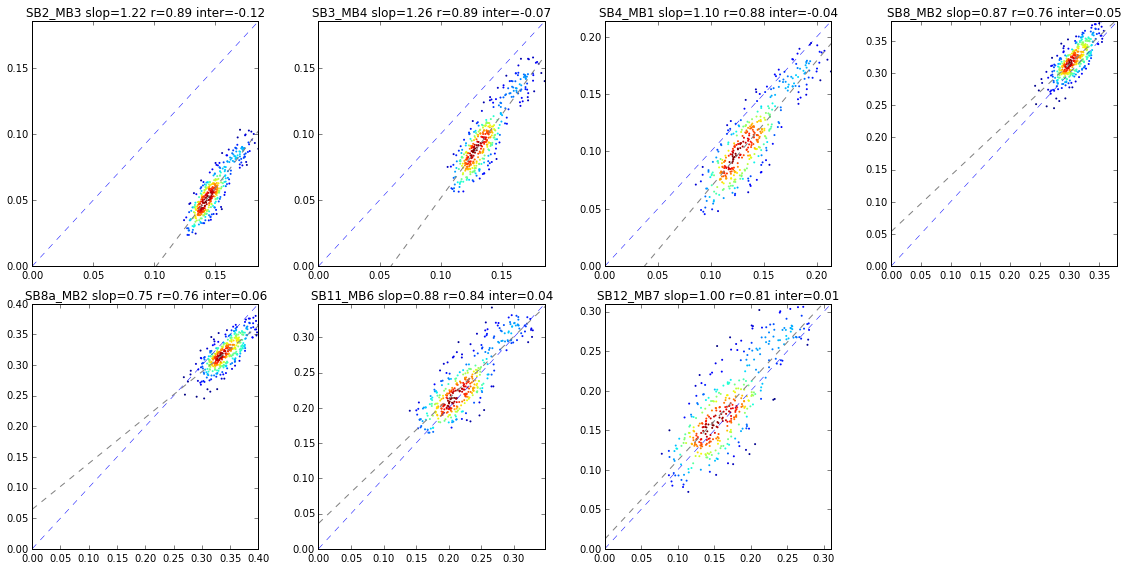

In [39]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(to_regs[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression0.pdf')

Apply the solved results to the whole image

In [40]:
b4_modis = parallel_rw_pkl(None, 'opb4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'opb2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'opb3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'opb8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'opb8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'opb11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'opb12_modis', 'r')

In [41]:
bands = []
for j in [b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    
    data = []
    for i in j:
        data+=i
    bands.append(data)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')

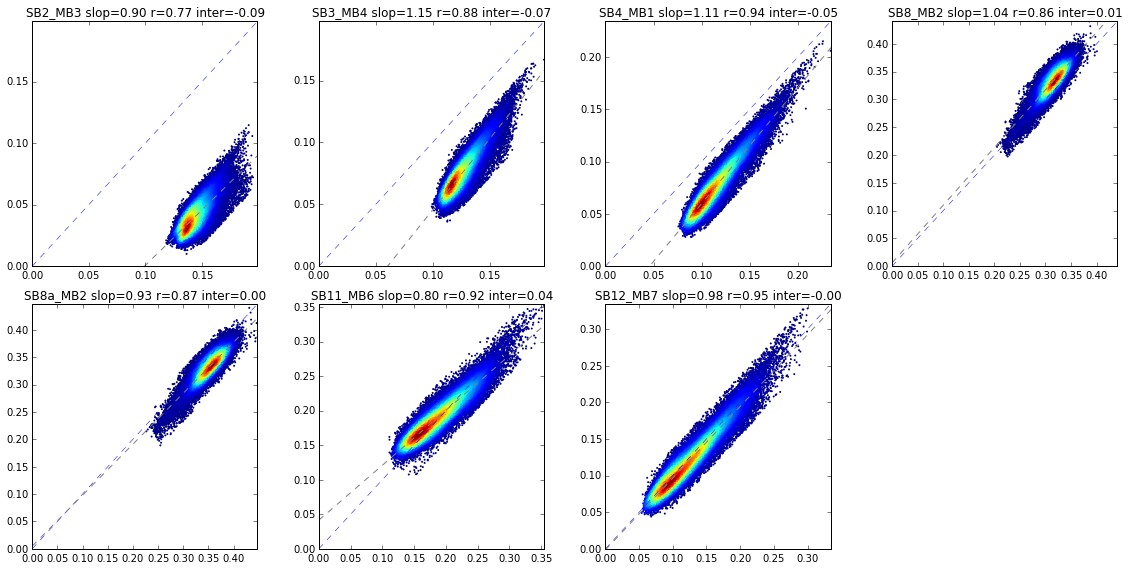

In [42]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()

Apply to patches with few influence from the cloud where 2% set as the threshold.

In [43]:
b4_modis = parallel_rw_pkl(None, 'opcfb4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'opcfb2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'opcfb3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'opcfb8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'opcfb8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'opcfb11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'opcfb12_modis', 'r')

In [44]:
bands = []
for j in [b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    
    data = []
    for i in j:
        data+=i
    bands.append(data)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')

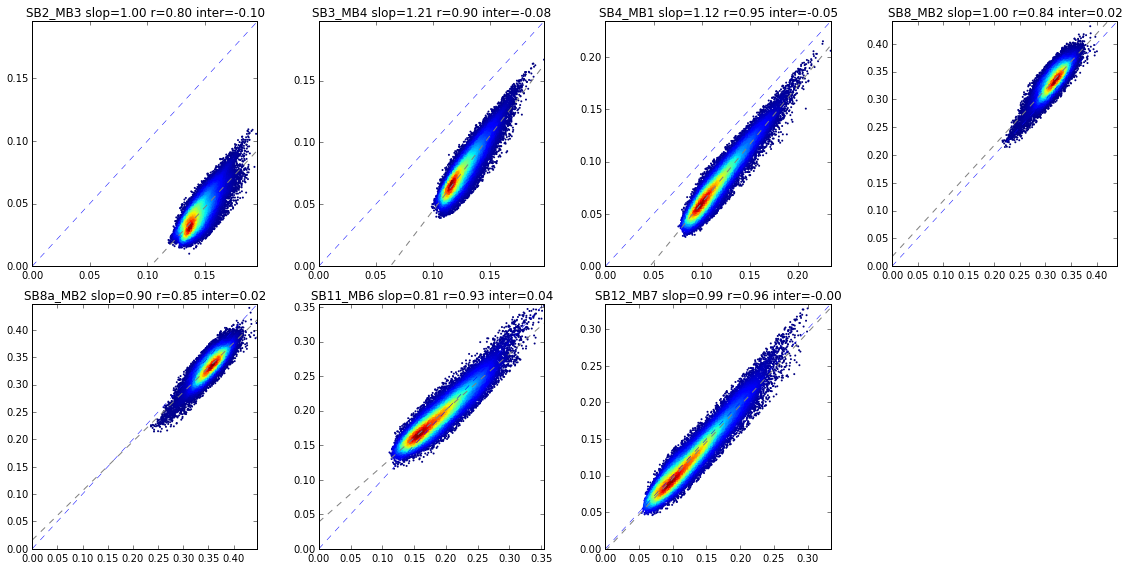

In [45]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()